# Quantum Approximate Optimization Algorithm


## Background

The Quantum Approximate Optimization Algorithm (QAOA) is a hybrid iterative method for solving combinatorial optimization problems. In this tutorial, we demonstrate how to implement the QAOA algorithm using Qiskit Runtime for solving a simple max-cut problem.

In a max-cut problem, we want to partition nodes of a graph in a way that maximizes the number of edges between nodes in differing groups. The desired max-cut partition for the following graph is clear: the 0th-node on the left should be separated from the rest of the nodes on the right by a cut. We will find this answer by applying QAOA by using Qiskit Runtime primitives and sessions.

## Setup

In [33]:
# General imports
import numpy as np

# Pre-defined ansatz circuit, operator class and visualization tools
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Sampler, Session, Options

# SciPy minimizer routine
from scipy.optimize import minimize

# rustworkx graph library
import rustworkx as rx
from rustworkx.visualization import mpl_draw

In [38]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

## Step 1: Map classical inputs to a quantum problem

To demonstrate max-cut, we'll create a graph using the [rustworkx library](https://github.com/Qiskit/rustworkx), and create Pauli Hamiltonian that encodes the cost in a manner such that the minimum expectation value of the operator corresponds to the maximum number of edges between the nodes in two different groups.

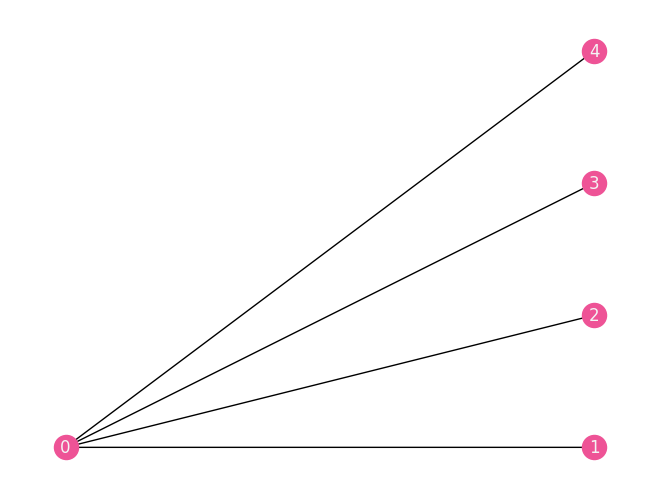

In [35]:
num_nodes = 5
# The edge syntax is (start, end, weight)
edges = [(0, 1, 1), (0, 2, 1), (0, 3, 1), (0, 4, 1)]

G = rx.PyGraph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edges)
mpl_draw(
    G, pos=rx.bipartite_layout(G, {0}), with_labels=True, node_color="#EE5396", font_color="#F4F4F4"
)

For this simple example, the operator is a linear combination of terms with `Z` operators on nodes connected by an edge (recall that the 0th qubit is farthest right): $IIIZZ + IIZIZ + IZIIZ + ZIIIZ$. Once the operator is constructed, the ansatz for the QAOA algorithm can easily be built by using the [`QAOAAnsatz`](https://docs.quantum-computing.ibm.com/api/qiskit/qiskit.circuit.library.QAOAAnsatz#qaoaansatz) circuit from the Qiskit circuit library.

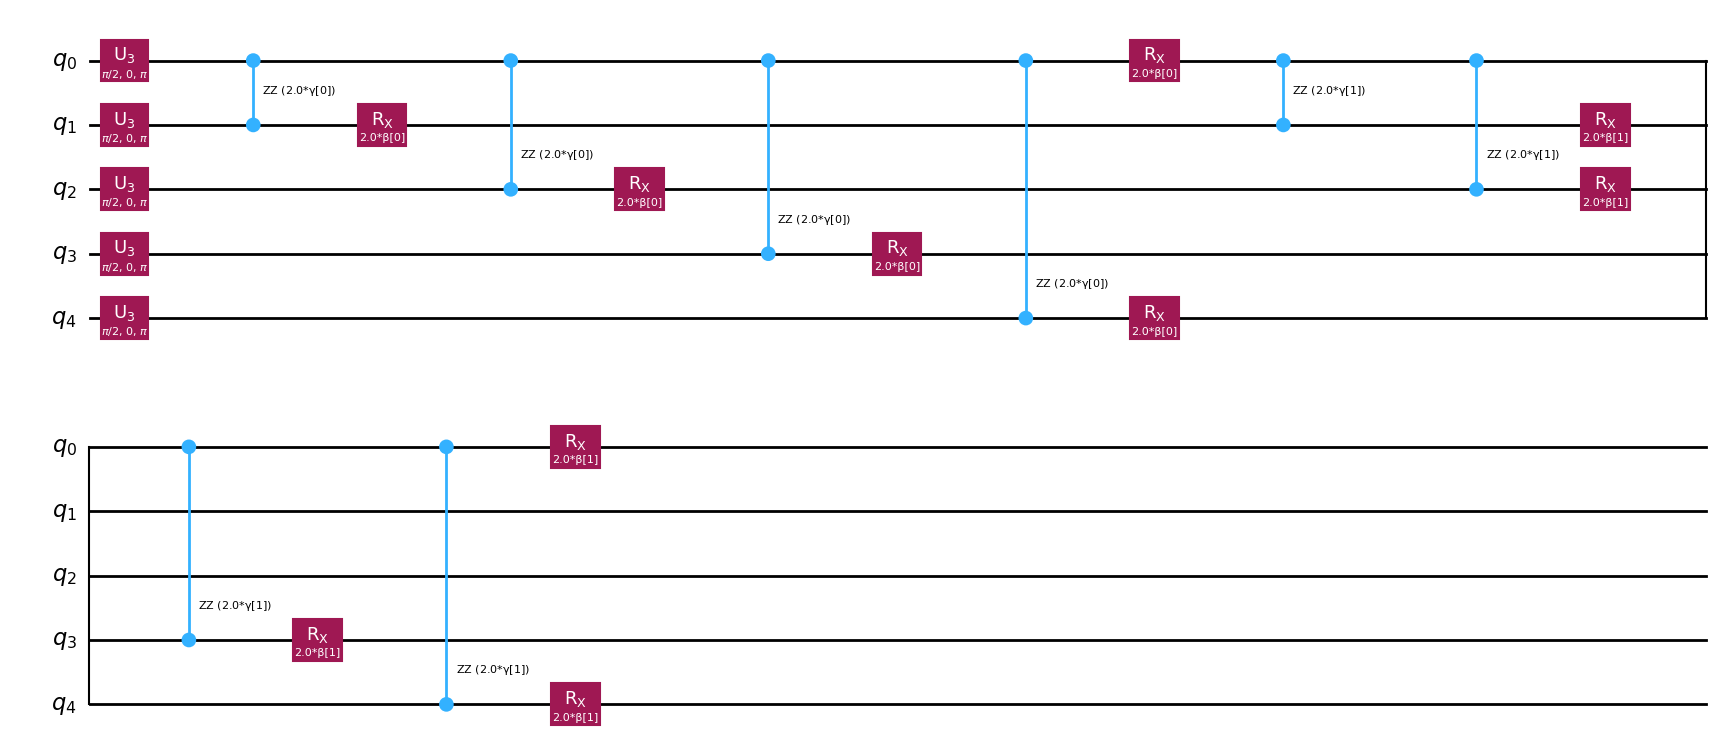

In [25]:
# Problem to Hamiltonian operator
hamiltonian = SparsePauliOp.from_list([("IIIZZ", 1), ("IIZIZ", 1), ("IZIIZ", 1), ("ZIIIZ", 1)])
# QAOA ansatz circuit
ansatz = QAOAAnsatz(hamiltonian, reps=2)

ansatz.decompose(reps=3).draw(output="mpl", style="iqp")

The previous image illustrates the ansatz in basic gates for clarity. However, it can be expressed in multiple levels of decomposition by changing the `reps` argument or by drawing the circuit without the `decompose` method. For example, the following representation directly shows the QAOA structure with the default `reps` value, which is `reps=1`. 

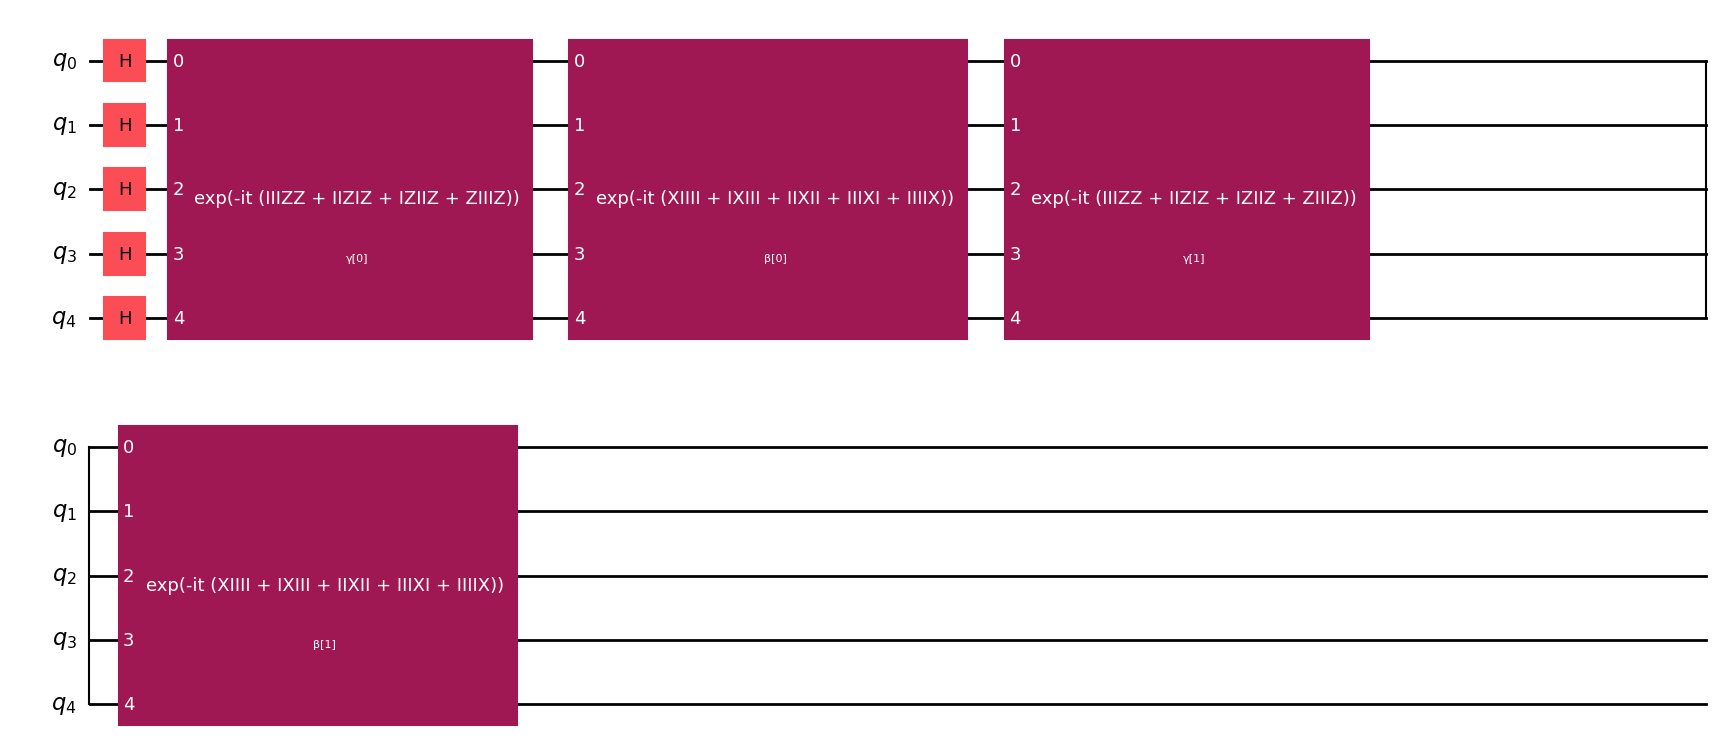

In [26]:
ansatz.decompose().draw(output="mpl", style="iqp")

## Step 2: Optimize problem for quantum execution.

We can schedule a series of [qiskit.transpiler](https://docs.quantum-computing.ibm.com/api/qiskit/transpiler) passes to optimize our circuit for a selected backend. This includes a few components:

- [`optimization_level`](https://docs.quantum-computing.ibm.com/api/qiskit/transpiler_preset#preset-pass-manager-generation): The lowest optimization level does the bare minimum needed to get the circuit running on the device; it maps the circuit qubits to the device qubits and adds swap gates to allow all 2-qubit operations. The highest optimization level is much smarter and uses lots of tricks to reduce the overall gate count. Since multi-qubit gates have high error rates and qubits decohere over time, the shorter circuits should give better results.
- [Dynamical Decoupling](https://docs.quantum-computing.ibm.com/api/qiskit-ibm-provider/qiskit_ibm_provider.transpiler.passes.scheduling.PadDynamicalDecoupling#paddynamicaldecoupling): We can apply a sequence of gates to idling qubits. This cancels out some unwanted interactions with the environment.

In [ ]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.transpiler.passes.scheduling import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
)
from qiskit.circuit.library import XGate

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(durations=target.durations()),
        PadDynamicalDecoupling(
            durations=target.durations(),
            dd_sequences=[XGate(), XGate()],
            pulse_alignment=target.pulse_alignment,
        ),
    ]
)

ansatz_ibm = pm.run(ansatz)

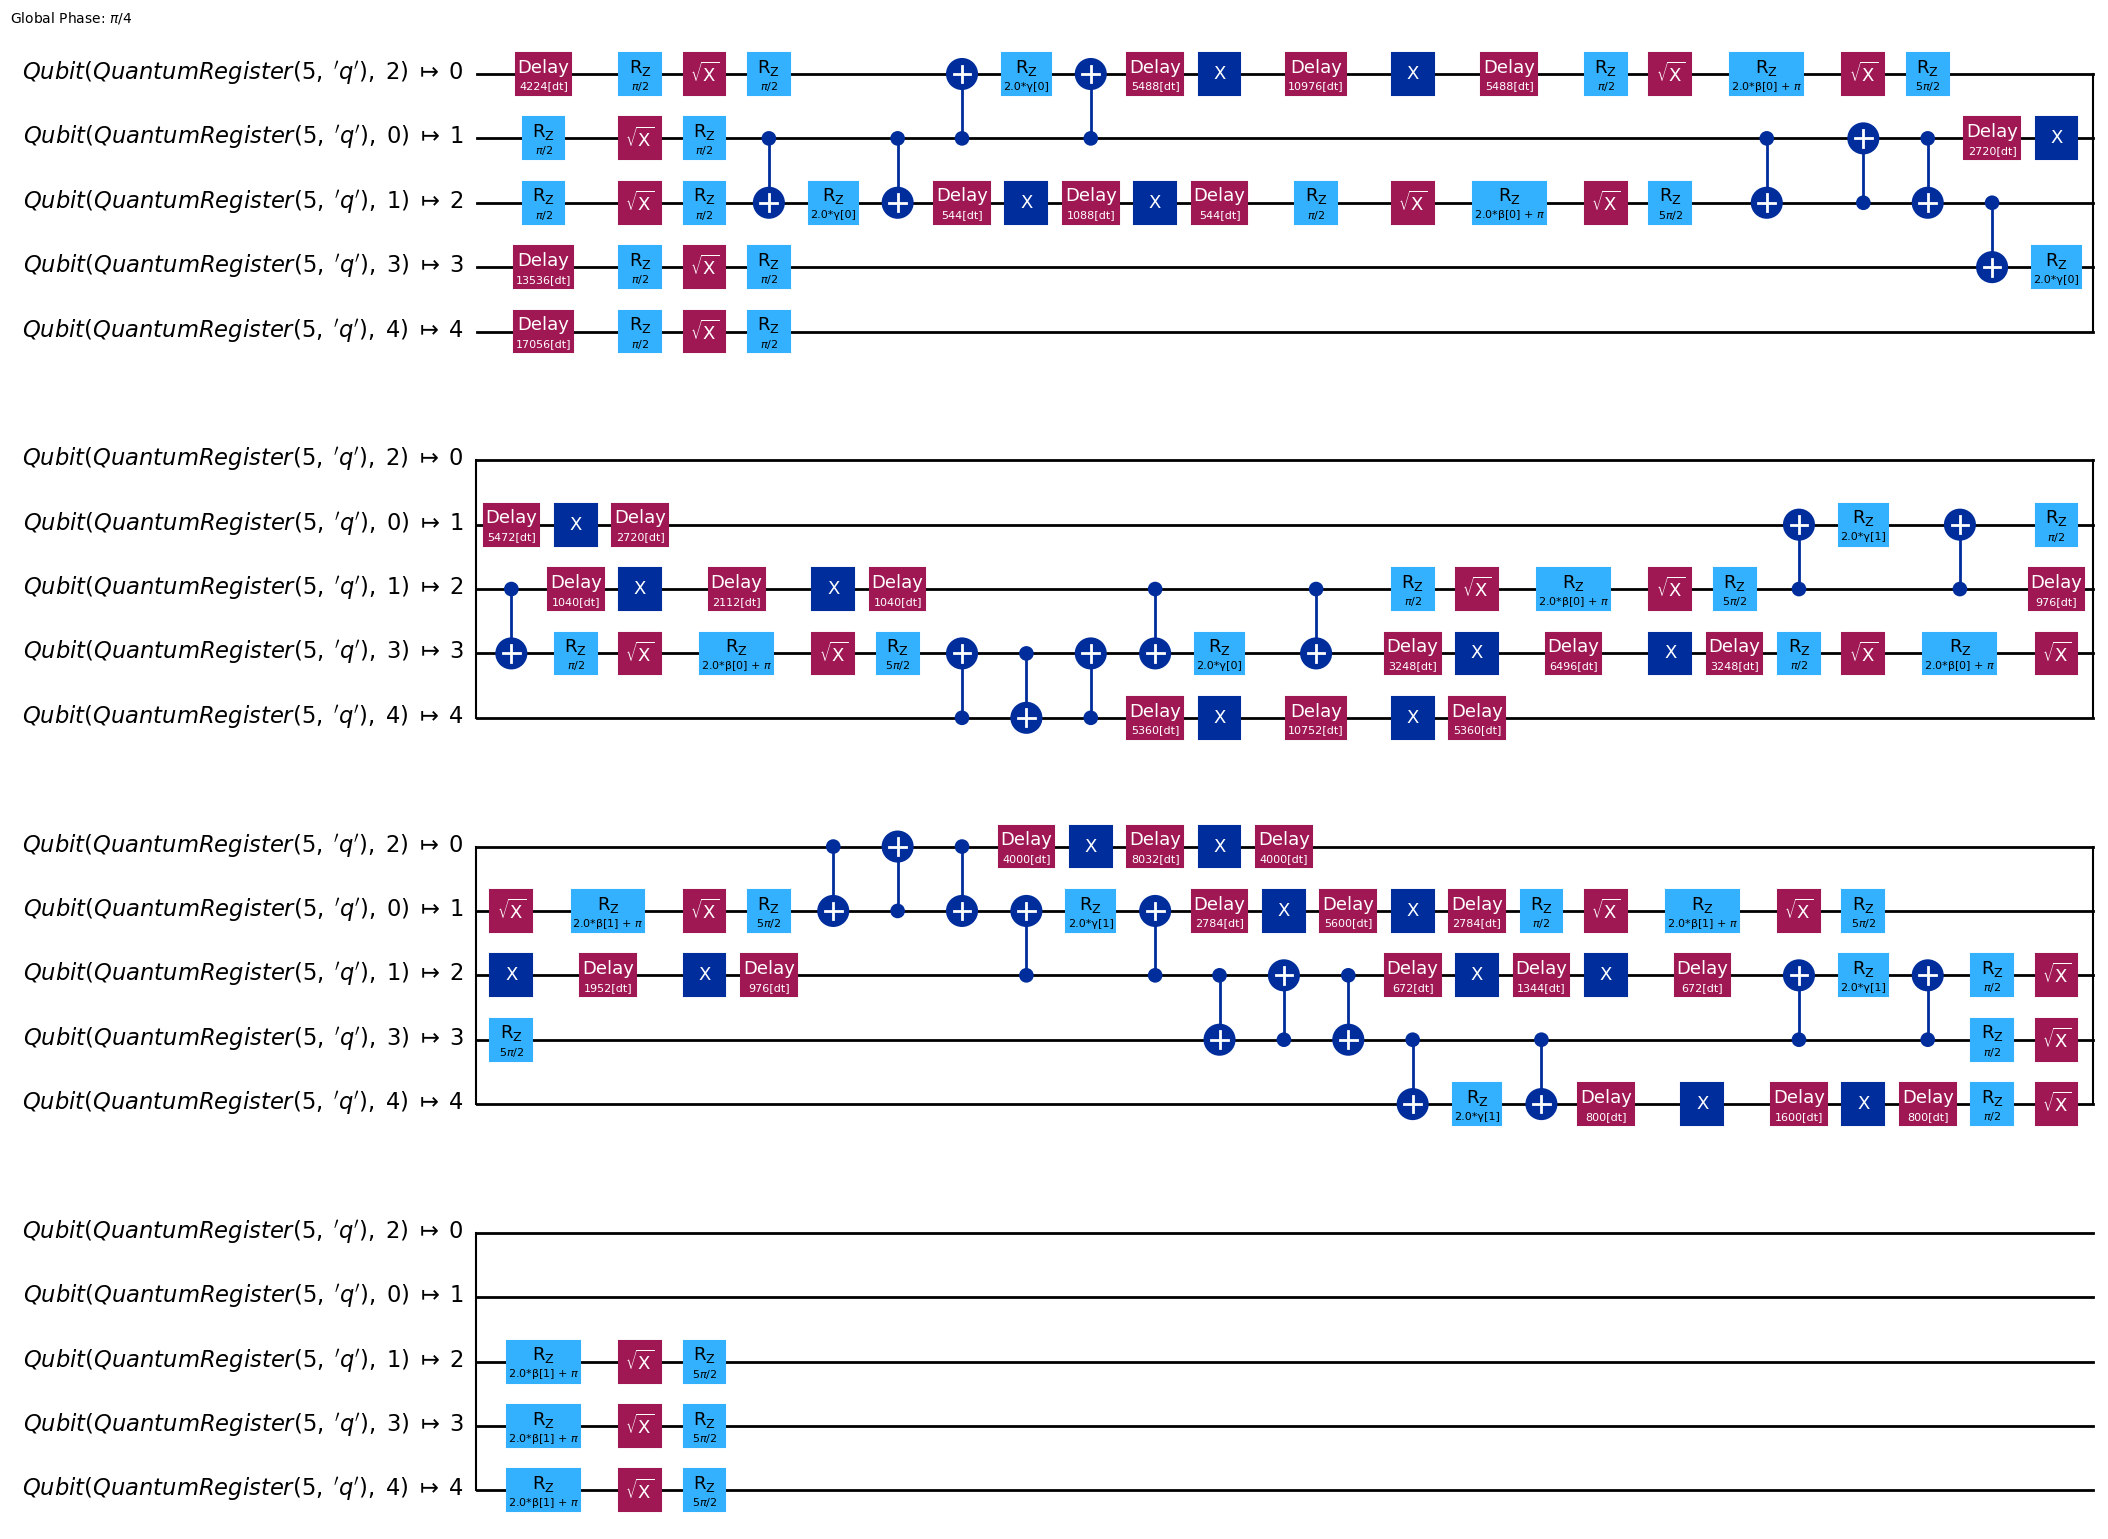

In [37]:
ansatz_ibm.draw(output="mpl", idle_wires=False, style="iqp")

We can also use `apply_layout` to transform our virtual observable to physical

In [31]:
hamiltonian_ibm = hamiltonian.apply_layout(ansatz_ibm.layout)
hamiltonian_ibm

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIZIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIZIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])

## Step 3: Execute using Qiskit Primitives.

As with an iterative optimization procedure, we now need to define our cost function over which to minimize.  We proceed in an identical manner to the [Variational Quantum Eigensolver tutorial](https://learning.quantum-computing.ibm.com/tutorial/variational-quantum-eigensolver), computing the expectation value of our Hamiltonian with respect to the parameterized ansatz circuit using the [Qiskit Runtime `Estimator`](https://docs.quantum-computing.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.Estimator#estimator) primitive:

In [32]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

Any classical optimizer can be used to minimize the cost function. On a real quantum system, an optimizer designed for non-smooth cost function landscapes usually does better. Here we use the [COBYLA routine from SciPy through the minimize function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html).

Because we are iteratively executing many calls to Runtime, we use a [`Session`](https://docs.quantum-computing.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.Session) to execute all calls within a single block. Moreover, for QAOA, the solution is encoded in the output distribution of the ansatz circuit bound with the optimal parameters from the minimization. Therefore, we will need a [`Sampler`](https://docs.quantum-computing.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.Sampler) primitive as well, and will instantiate it with the same [`Session`](https://docs.quantum-computing.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.Session).


In [95]:
# To run on local simulator:
#   1. Use the Estimator from qiskit.primitives instead.
#   2. Remove the Session context manager below.

options = Options()
options.transpilation.skip_transpilation = True
options.execution.shots = 10000

session = Session(backend=backend)

estimator = Estimator(session=session, options={"shots": int(1e4)})
sampler = Sampler(session=session, options={"shots": int(1e4)})

We can set an initial set of random parameters:

In [12]:
x0 = 2 * np.pi * np.random.rand(ansatz_ibm.num_parameters)

We can run our minimization routine:

In [13]:
res = minimize(cost_func, x0, args=(ansatz_ibm, hamiltonian_ibm, estimator), method="COBYLA")

In the end, we have a result in the standard [SciPy `OptimizeResult`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html) format.

In [14]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.1833650134933325
       x: [ 5.739e+00  2.804e+00  9.282e-01  5.858e+00]
    nfev: 62
   maxcv: 0.0

## Step 4: Post-process, return result in classical format.

The solution vector of parameter angles (`x`), when plugged into the `ansatz` circuit, yields the graph partitioning that we were looking for.

In [15]:
# Assign solution parameters to ansatz
qc = ansatz.assign_parameters(res.x)
# Add measurements to our circuit
qc.measure_all()

In [17]:
# Sample ansatz at optimal parameters
samp_dist = sampler.run(qc).result().quasi_dists[0]
# Close the session since we are now done with it
session.close()

For small problem instances, the solution can be visually obtained:

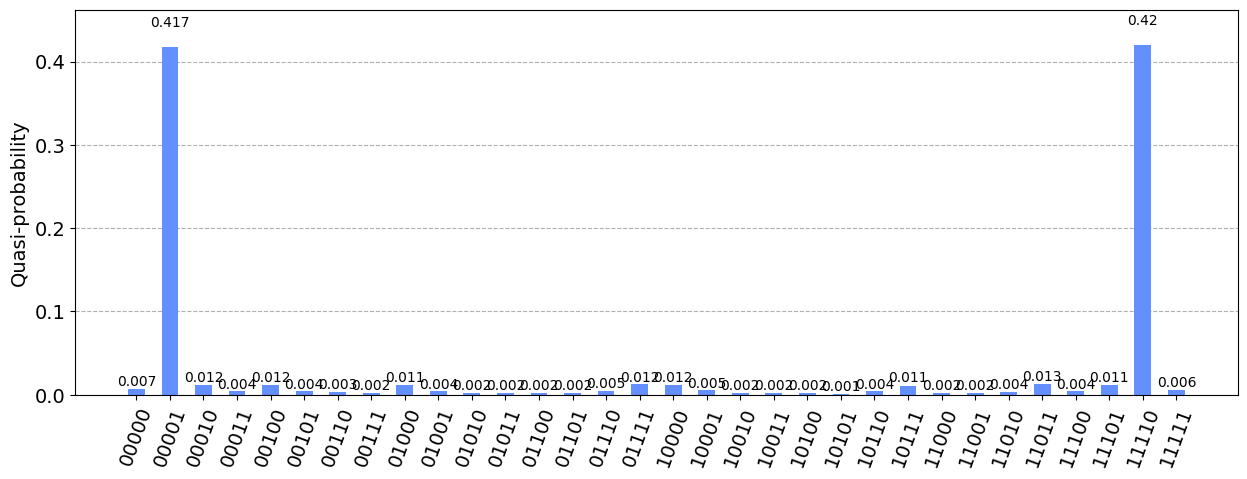

In [18]:
plot_distribution(samp_dist.binary_probabilities(), figsize=(15, 5))

The most probable bit-strings, up to finite-sampling deviations, encode the solution.  Here we see that `00001` and `11110` are found, and are indeed correct.  There are two solutions because the labeling of the two partitions with `'0'` or `'1'` is arbitrary.

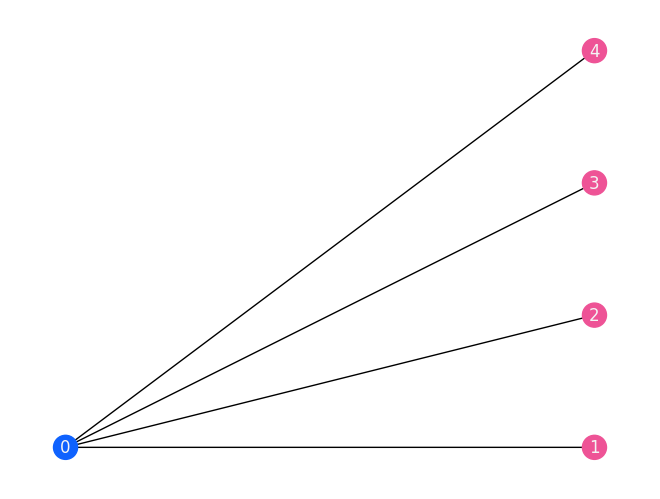

In [19]:
# Reverse 11110 to convert quantum result to classical solution
solution = [0, 1, 1, 1, 1]

mpl_draw(
    G,
    pos=rx.bipartite_layout(G, {0}),
    with_labels=True,
    node_color=["#EE5396" if kk else "#0F62FE" for kk in solution],
    font_color="#F4F4F4",
)

In [20]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.14.1'

In [21]:
import qiskit

qiskit.version.get_version_info()

'0.45.0'